# # Modulo 34 - Regressão III - Tarefa

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings;   warnings.filterwarnings("ignore")

from scipy.interpolate import interp1d

%matplotlib inline

In [52]:
df = pd.read_csv('previsao_de_renda2.csv', index_col=0)
df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


---

## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [53]:
df.isnull().sum()

data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [54]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df.isnull().sum()

data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [55]:
print(df.index.min())
print(df.index.max())

0
14999


In [56]:
# Convertendo o índice para datetime
df.index = pd.to_datetime(df.index)

# Agora você pode fazer a indexação
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]


---

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [57]:
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_train)

In [58]:
res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)

resumo = res.summary()
resumo.tables[0]

Dep. Variable:,np.log(renda),R-squared:,0.333
Model:,OLS,Adj. R-squared:,0.332
Method:,Least Squares,F-statistic:,1869.
Date:,"Mon, 25 Mar 2024",Prob (F-statistic):,0.00
Time:,12:45:39,Log-Likelihood:,-16392.
No. Observations:,15000,AIC:,3.279e+04
Df Residuals:,14996,BIC:,3.283e+04
Df Model:,4,,
Covariance Type:,nonrobust,,


In [59]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05, axis=1, props='color:red', subset='P>|t|'
).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"7,4181","0,0260","287,2960","0,0000","7,3680","7,4690"
C(sexo)[T.M],"0,8007","0,0130","61,8510","0,0000","0,7750","0,8260"
C(posse_de_veiculo)[T.True],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_imovel)[T.True],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Bolsista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Empresário],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Pensionista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Servidor público],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Primário]","0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Pós graduação]","0,0000","0,0000",nan,nan,"0,0000","0,0000"


---

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [60]:
df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)

In [61]:
df_train.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat
1970-01-01 00:00:00.000000000,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,"(6.258, 7.027]"
1970-01-01 00:00:00.000000001,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,"(7.027, 8.047]"
1970-01-01 00:00:00.000000002,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,"(0.835, 1.433]"
1970-01-01 00:00:00.000000003,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,"(4.288, 4.932]"
1970-01-01 00:00:00.000000004,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,"(4.288, 4.932]"


In [62]:
quebras

array([ 0.11780822,  0.83534247,  1.43287671,  2.05753425,  2.85753425,
        3.60273973,  4.28767123,  4.93150685,  5.73150685,  6.01369863,
        6.25753425,  7.02739726,  8.04657534,  8.96164384, 10.3890411 ,
       12.4630137 , 15.30136986, 20.1890411 , 42.90684932])

In [63]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins=quebras, duplicates='drop')

In [64]:
df_train.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat
1970-01-01 00:00:00.000000000,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,"(6.258, 7.027]"
1970-01-01 00:00:00.000000001,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,"(7.027, 8.047]"
1970-01-01 00:00:00.000000002,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,"(0.835, 1.433]"
1970-01-01 00:00:00.000000003,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,"(4.288, 4.932]"
1970-01-01 00:00:00.000000004,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,"(4.288, 4.932]"


In [65]:
# Criando tabela de perfil

tab_perfil = pd.DataFrame()

# Coluna para a quantidade de observações de cada categoria

tab_perfil['qtd_obs'] = df_train['tempo_emprego_cat'].value_counts()

# Coluna para a média do log-renda para cada categoria

df_train['log_renda']=np.log(df_train['renda'])

tab_perfil['log_renda_med'] = df_train.groupby('tempo_emprego_cat')['log_renda'].mean()

# Coluna para a média do tempo de emprego para cada categoria

tab_perfil['tempo_emprego_med'] = df_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()

tab_perfil.sort_index(axis = 0, inplace = True)

tab_perfil.reset_index(inplace=True)

tab_perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)

tab_perfil

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.118, 0.835]",748,7.789267,0.532906
1,"(0.835, 1.433]",771,7.858843,1.132502
2,"(1.433, 2.058]",738,7.874245,1.762494
3,"(2.058, 2.858]",744,7.953627,2.473862
4,"(2.858, 3.603]",760,7.992545,3.242891
5,"(3.603, 4.288]",746,8.072962,3.951122
6,"(4.288, 4.932]",749,8.115736,4.602257
7,"(4.932, 5.732]",745,8.187622,5.367638
8,"(5.732, 6.014]",2786,7.944724,6.003948
9,"(6.014, 6.258]",213,8.024770,6.114631


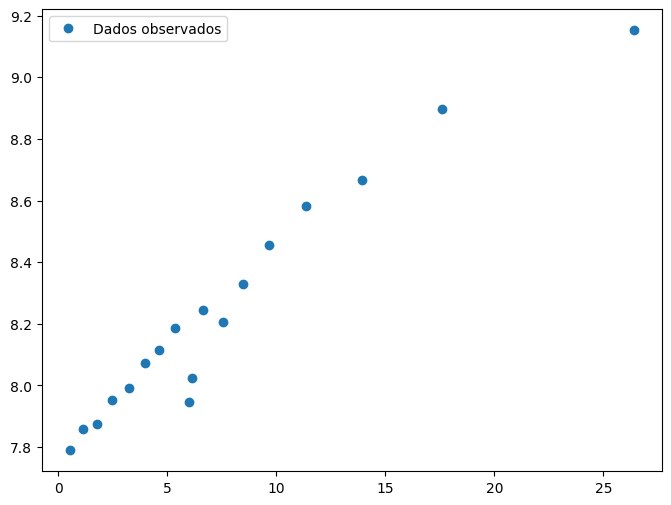

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(tab_perfil.tempo_emprego_med, tab_perfil.log_renda_med, "o", label="Dados observados", alpha=1)
ax.legend()


---

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [67]:
df_train_b = df_train.merge(tab_perfil, on='tempo_emprego_cat', how='left')
df_train_b.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,"(6.258, 7.027]",8.994711,750.0,8.244878,6.637078
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,"(7.027, 8.047]",7.524102,753.0,8.204104,7.545991
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,"(0.835, 1.433]",7.720413,771.0,7.858843,1.132502
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,"(4.288, 4.932]",8.794942,749.0,8.115736,4.602257
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,"(4.288, 4.932]",8.775854,749.0,8.115736,4.602257


In [68]:
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_cat 
                    + 1''', df_train_b)

res_2 = smf.ols(X2, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_2.rsquared_adj:.2%}')

R-quadrado ajustado: 16.84%


In [69]:
%%time
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_train_b.log_renda, df_train_b.tempo_emprego, frac=2/3)

CPU times: total: 2.47 s
Wall time: 2.7 s


In [70]:
# Valores de X,Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_b['tempo_emprego_lowess'] = f(df_train_b.tempo_emprego)
df_train_b.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med,tempo_emprego_lowess
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,"(6.258, 7.027]",8.994711,750.0,8.244878,6.637078,8.123407
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,"(7.027, 8.047]",7.524102,753.0,8.204104,7.545991,8.171957
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,"(0.835, 1.433]",7.720413,771.0,7.858843,1.132502,7.850578
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,"(4.288, 4.932]",8.794942,749.0,8.115736,4.602257,8.030964
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,"(4.288, 4.932]",8.775854,749.0,8.115736,4.602257,8.013660


In [71]:
X3 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_train_b)

res_3 = smf.ols(X3, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_3.rsquared_adj:.2%}')

R-quadrado ajustado: 16.91%


---

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [72]:
# Regressão inicial

df_test['log_renda']=np.log(df_test['renda'])

df_test['pred_1'] = res.predict(df_test)

r = df_test[['pred_1', 'log_renda']].corr().iloc[0,1]
r**2

nan

In [73]:
# Categorização

df_test['tempo_emprego_cat'] = pd.cut(df_test.tempo_emprego, bins = quebras, duplicates='drop')

warnings.filterwarnings('ignore')

In [74]:
df_test['tempo_emprego_cat'].isna().value_counts()

Series([], Name: count, dtype: int64)

In [75]:
df_test.dropna(inplace=True)

In [76]:
df_test['pred_2'] = res_2.predict(df_test)

In [77]:
r = df_test[['pred_2', 'log_renda']].corr().iloc[0,1]
r**2


nan

In [78]:
%%time
# Lowess

# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_test.log_renda, df_test.tempo_emprego, frac=2/3)

CPU times: total: 0 ns
Wall time: 0 ns


In [79]:
# Verifica se lowess retornou dados
if len(lowess) == 0:
    print("Erro: lowess retornou nenhum dado. Verifique seus parâmetros.")
else:
    lowess_x = lowess[:, 0]
    lowess_y = lowess[:, 1]

    if len(lowess_x) == 0 or len(lowess_y) == 0:
        print("Erro: lowess_x ou lowess_y estão vazios. Verifique seus dados.")
    else:
        # Roda a interpolação do scipy
        f = interp1d(lowess_x, lowess_y, bounds_error=False)

        df_test['tempo_emprego_lowess'] = f(df_test.tempo_emprego)
        df_test.head(2)


Erro: lowess retornou nenhum dado. Verifique seus parâmetros.


In [81]:
df_test['pred_3'] = res_3.predict(df_test)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'tempo_emprego_lowess' is not defined
    log_renda ~                      + C(posse_de_imovel)                     + qtd_filhos                      + idade                     + tempo_emprego_lowess                      + 1
                                                                                                                                              ^^^^^^^^^^^^^^^^^^^^

In [ ]:
r = df_test[['pred_3', 'log_renda']].corr().iloc[0,1]
r**2

---